In [102]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.utils import resample
import math as math

In [103]:
Data = pd.read_csv('House_Price_Regression.csv')

Data = Data.loc[:, ['latitude', 'longitude', 'price', 'size_in_m_2']]

Data.head()

,latitude,longitude,price,size_in_m_2
0,25.113208,55.138932,2700000,100.242337
1,25.106809,55.151201,2850000,146.972546
2,25.063302,55.137728,1150000,181.253753
3,25.227295,55.341761,2850000,187.664060
4,25.114275,55.139764,1729200,47.101821


In [104]:
Data_numpy = Data.to_numpy()

## Distancias

In [105]:
def Dist_Euclidea(x_i, x_r):

        Dist_Euclidea = ( ( x_i - x_r )**2 ).sum()

        Dist_Euclidea = np.sqrt(Dist_Euclidea)

        return Dist_Euclidea

In [106]:
def Matrix_Dist_Euclidea(Data):

    # Paso previo necesario si Data es pd.DataFrame  -->  Data = Data.to_numpy()

    n = len(Data)

    M =  np.empty((n , n))

    
    for i in range(0, n):

         for r in range(0, n):

             if i >= r :
               
                 M[i,r] = 0

             else :

                 M[i,r] = Dist_Euclidea(Data[i,:] , Data[r,:])   

                      
    return M 

In [107]:
def Dist_Minkowski(x_i, x_r, q):

    Dist_Minkowski = ( ( ( abs( x_i - x_r) )**q ).sum() )**(1/q)

    return Dist_Minkowski

In [108]:
def Matrix_Dist_Minkowski(Data, q):

    # Paso previo necesario si Data es pd.DataFrame  -->  Data = Data.to_numpy()

    n = len(Data)

    M =  np.empty((n , n))

    
    for i in range(0, n):

         for r in range(0, n):

             if i >= r :
               
                 M[i,r] = 0

             else :

                 M[i,r] = Dist_Minkowski(Data[i,:] , Data[r,:], q)   

                      
    return M 

In [109]:
def Dist_Canberra(x_i, x_r):

    numerator =  abs( x_i - x_r )

    denominator =  ( abs(x_i) + abs(x_r) )
       
    numerator=np.array([numerator], dtype=float)

    denominator=np.array([denominator], dtype=float)

    # The following code is to eliminate zero division problems

    Dist_Canberra = ( np.divide( numerator , denominator , out=np.zeros_like(numerator), where=denominator!=0) ).sum() 

    return Dist_Canberra

In [110]:
def Matrix_Dist_Canberra(Data):

    # Paso previo necesario si Data es pd.DataFrame  -->  Data = Data.to_numpy()

    n = len(Data)

    M =  np.empty((n , n))

    
    for i in range(0, n):

         for r in range(0, n):

             if i >= r :
               
                 M[i,r] = 0

             else :

                 M[i,r] = Dist_Canberra(Data[i,:] , Data[r,:])   

                      
    return M 

In [111]:
def Dist_Mahalanobis_2(x_i, x_r, S_inv):  # Más eficiente que la anterior

    # All the columns of Data must be type = 'float' or 'int' (specially not 'object'), in other case we will find 
    # dimensional problems when Python compute   x @ S_inv @ x.T

    x = (x_i - x_r)
    
    # x = np.array([x]) 
    
    # En este caso este paso no será necesario por el tipo de estructura Python (una lista) que va a ser un medoid en el
    # algoritmo que a continuación definiremos. De hecho si este paso no se suprimer salta un error al usar la distancia
    # de Mahalanobis, puesto que la operacion x @ S_inv @ x.T no está bien definida.

    Dist_Maha = np.sqrt( x @ S_inv @ x.T )  # x @ S_inv @ x.T = np.matmul( np.matmul(x , S_inv) , x.T )

    Dist_Maha = float(Dist_Maha)

    return Dist_Maha

In [112]:
def Dist_Mahalanobis_3(x, S_inv):  # Más eficiente que la anterior

    # All the columns of Data must be type = 'float' or 'int' (specially not 'object'), in other case we will find 
    # dimensional problems when Python compute   x @ S_inv @ x.T

    # x = (x_i - x_r)

    # x = np.array([x]) # necessary step to transpose a 1D array

    Dist_Maha = np.sqrt( x @ S_inv @ x.T )  # x @ S_inv @ x.T = np.matmul( np.matmul(x , S_inv) , x.T )

    Dist_Maha = float(Dist_Maha)

    return Dist_Maha

In [113]:
def Matrix_Dist_Mahalanobis_3(Data):

    # Paso previo necesario si Data es pd.DataFrame  -->  Data = Data.to_numpy()

    n = len(Data)

    M =  np.empty((n , n))

    S_inv=np.linalg.inv( np.cov(Data , rowvar=False) )

   
    for i in range(0, n):

         for r in range(0, n):

             if i >= r :
               
                 M[i,r] = 0

             else :

                 M[i,r] = Dist_Mahalanobis_3(x = np.array([Data[i,:] - Data[r,:]]) , S_inv=S_inv ) 

                      
    return M 

## K-medoids de Park y Jun modificando la definicion de los clusters iniciales

In [114]:
def k_medoids(Data, Distance_function, q, S_inv, Distance_Matrix, random_seed, k, max_n_iter):

    # Data --> a numpy array
    # Distance_function --> a distance function betwwen arrays
    # q --> parametro necesario si se usa la distancia Minkowski
    # S_inv --> parametro necesario si se usa la distancia Mahalanobis
    # Distance_Matriz --> a distance matrix (en forma completa)
    # random_seed --> semilla aleatoria
    # k --> nº clusters
    # max_n_iter --> nº maximo de iteraciones del algoritmo

###########################################################################################

    lista_df_clusters_finales_iter = []

###########################################################################################

# Se generan los clusters iniciales aleatoreamente

    sample = resample(range(0, len(Data)), n_samples=len(Data), replace=False, random_state=random_seed)

    df_sample = pd.DataFrame({'index': range(0,len(Data)) , 'sample':sample})

    Q = []

    for q in np.arange(0 , 1 + 1/k , 1/k):

        Q.append( np.quantile( range(0, len(Data)) , q ).round(0) )



    labels_clusters = np.array([0])

    for j in range(0,k):
   
        labels_clusters = np.concatenate([labels_clusters, np.repeat( j, len( df_sample.loc[Q[j]:(math.floor(Q[j+1])-1), 'sample'] ) ) ] ) 
 

    df_cluster = pd.DataFrame({'observacion': df_sample['sample'] , 'cluster': labels_clusters})

    lista_df_clusters_finales_iter.append(df_cluster)

###########################################################################################


# calculamos los medoids de los clusters iniciales

    M = Distance_Matrix

   ######################

    medoids = []

    for j in range(0, k):

      observations_cluster_j = df_cluster.loc[df_cluster.cluster == j ,].observacion

      M_j = M[observations_cluster_j, :][: ,observations_cluster_j] # matriz distancias para el cluster j

      suma_distancias = M_j.sum(axis=1) # suma de la matriz por filas

      h = np.where( suma_distancias == min( suma_distancias ) ) # indice en la matriz de la observacion que minimiza la suma de distancias en el cluster j --> medoid del cluster j

      d = df_cluster.loc[df_cluster.cluster == j , ]    

      # d.iloc[h[0],:].observacion es el indice en el data set original de la observacion medoid del cluster j 


      if len(h[0]) == 1 : 
        
        medoids.append( Data[ d.iloc[h[0],:].observacion , : ]  ) # su componente j es el medoid del cluster j

      if len(h[0]) > 1 : 
        
        medoids.append( Data[ int(d.iloc[h[0][0],:].observacion)  , : ]  ) # su componente j es el medoid del cluster j

      # Los condicionales son para evitar problemas en el caso de que en un cluster haya mas de un medoid.
      # Puede haber dos o mas observaciones que cumplan con la definicion de medoid, para alguno de los clusters.
      # Si un cluster tiene varios medoids, nos quedamos solo con uno.

###########################################################################################


   # Calculamos la suma de varianzas intra cluster para los clusters iniciales

    lista_suma_varianzas_intra_cluster = []

    distancias, varianzas_intra_cluster , suma_varianzas_intra_cluster = [], [], []

    for j in range(0,k):

        for i in df_cluster.loc[df_cluster.cluster == j, 'observacion']:

            if Distance_function == Dist_Euclidea: distancias.append( Distance_function( Data[i,:] , medoids[j] ) )

            if Distance_function == Dist_Minkowski: distancias.append( Distance_function( Data[i,:] , medoids[j] , q ) )

            if Distance_function == Dist_Canberra: distancias.append( Distance_function( Data[i,:] , medoids[j] ) )

            if Distance_function == Dist_Mahalanobis_2: distancias.append( Distance_function( Data[i,:] , medoids[j] , S_inv) )
            

        varianzas_intra_cluster.append( sum(distancias) )


    suma_varianzas_intra_cluster.append( sum(varianzas_intra_cluster) )

    lista_suma_varianzas_intra_cluster.append( suma_varianzas_intra_cluster )


###########################################################################################


# Asignar cada observacion a su cluster más cercano 


    for r in range(0 , max_n_iter):


       # Calculamos los nuevos clusters 

        labels_clusters = []

        for i in df_sample['sample']:

            distancias = []
    
            for j in range(0,k):

                if Distance_function == Dist_Euclidea: distancias.append( Distance_function( Data[i,:] , medoids[j] ) )

                if Distance_function == Dist_Minkowski: distancias.append( Distance_function( Data[i,:] , medoids[j] , q ) )

                if Distance_function == Dist_Canberra: distancias.append( Distance_function( Data[i,:] , medoids[j] ) )

                if Distance_function == Dist_Mahalanobis_2: distancias.append( Distance_function( Data[i,:] , medoids[j] , S_inv) )
            

                

            df_distancias = pd.DataFrame({'Distancias' : distancias , 'Cluster': range(0,k)})

            df_distancias_sort = df_distancias.sort_values(by='Distancias', ascending=True)

            labels_clusters.append( df_distancias_sort.iloc[0]['Cluster'] )

        
        
        df_cluster = pd.DataFrame({'observacion' : df_sample['sample'] , 'cluster': labels_clusters})


###########################################################################################


       # Calculamos los medoids de los nuevos clusters

        medoids = []
        label_medoids =[]


        for j in range(0, k):                    
                
                observations_cluster_j = df_cluster.loc[df_cluster.cluster == j ,].observacion

                M_j = M[observations_cluster_j, :][: ,observations_cluster_j] # matriz distancias para el cluster j

                suma_distancias = M_j.sum(axis=1) # suma de la matriz por filas

                h = np.where( suma_distancias == min( suma_distancias) ) # indice en la matriz de la observacion que minimiza la suma de distancias en el cluster j --> medoid del cluster j

                d = df_cluster.loc[df_cluster.cluster == j , ]    

                # d.iloc[h[0],:].observacion  es el indice en el data set original de la observacion medoid del cluster j 
                
                if len(h[0]) == 1 : 
                    
                    medoids.append( Data[ d.iloc[h[0],:].observacion , : ]  )   # su componente j es el medoid del cluster j

                    label_medoids.append(d.iloc[h[0],:].observacion)


                elif len(h[0]) > 1 : 
                  
                    medoids.append( Data[ int(d.iloc[h[0][0],:].observacion)  , : ]  ) # su componente j es el medoid del cluster j
                
                    label_medoids.append( int(d.iloc[h[0][0],:].observacion) )
                
                # Los condicionales son para evitar problemas en el caso de que en un cluster haya mas de un medoid.
                # Puede haber dos o mas observaciones que cumplan con la definicion de medoid, para alguno de los clusters.
                # Si un cluster tiene varios medoids, nos quedamos solo con uno.

###########################################################################################

        # Calculamos la suma de varianzas intra cluster para los nuevos clusters

        distancias, varianzas_intra_cluster , suma_varianzas_intra_cluster = [], [], []

        for j in range(0,k):

            for i in df_cluster.loc[df_cluster.cluster == j, 'observacion']:

                if Distance_function == Dist_Euclidea: distancias.append( Distance_function( Data[i,:] , medoids[j] ) )

                if Distance_function == Dist_Minkowski: distancias.append( Distance_function( Data[i,:] , medoids[j] , q ) )

                if Distance_function == Dist_Canberra: distancias.append( Distance_function( Data[i,:] , medoids[j] ) )

                if Distance_function == Dist_Mahalanobis_2: distancias.append( Distance_function( Data[i,:] , medoids[j] , S_inv) )


            varianzas_intra_cluster.append( sum(distancias) )


        suma_varianzas_intra_cluster.append( sum(varianzas_intra_cluster) )

        lista_suma_varianzas_intra_cluster.append( suma_varianzas_intra_cluster )

    ###########################################

        df_clusters_finales_iter = pd.DataFrame({'observaciones': df_sample['sample']  , 'cluster': labels_clusters })

        lista_df_clusters_finales_iter.append(df_clusters_finales_iter)

######################################################################################
######################################################################################

    from itertools import chain

    # unlist a list:

    lista_suma_varianzas_intra_cluster = list(chain.from_iterable(lista_suma_varianzas_intra_cluster))

    df_suma_varianzas_intra_cluster = pd.DataFrame({'sum_var_intra_cluster':lista_suma_varianzas_intra_cluster  , 'iter': range(0, max_n_iter+1)})
    
    sort_df_suma_varianzas_intra_cluster = df_suma_varianzas_intra_cluster.sort_values(by='sum_var_intra_cluster', ascending=True)
    

######################################################################################

    return lista_df_clusters_finales_iter , sort_df_suma_varianzas_intra_cluster,  df_suma_varianzas_intra_cluster


### Prueba con la distancia Euclidea

In [115]:
Distance_Matrix = Matrix_Dist_Euclidea(Data_numpy)

In [116]:
Distance_Matrix = Distance_Matrix + Distance_Matrix.T

In [117]:
lista_df_clusters_finales_iter,  sort_df_suma_varianzas_intra_cluster, df_suma_varianzas_intra_cluster = k_medoids(Data=Data_numpy , Distance_function=Dist_Euclidea, q=1, S_inv='none', Distance_Matrix=Distance_Matrix, random_seed=123, k=4, max_n_iter=50)


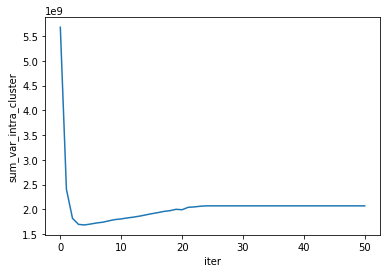

In [ ]:
plot = sns.lineplot(data=df_suma_varianzas_intra_cluster, y='sum_var_intra_cluster', x='iter')

In [ ]:
sort_df_suma_varianzas_intra_cluster.head(7)

,sum_var_intra_cluster,iter
4,1.683331e+09,4
3,1.693215e+09,3
5,1.701915e+09,5
6,1.723348e+09,6
7,1.738627e+09,7
8,1.766953e+09,8
9,1.791426e+09,9


In [ ]:
lista_df_clusters_finales_iter[4]

,observaciones,cluster
0,382,3.0
1,732,2.0
2,1888,1.0
3,679,1.0
4,1004,3.0
...,...,...
1900,1122,0.0
1901,1346,1.0
1902,1406,0.0
1903,1389,2.0


### Prueba distancia Minkowski

In [ ]:
Distance_Matrix = Matrix_Dist_Minkowski(Data_numpy , q=1)

In [ ]:
Distance_Matrix = Distance_Matrix + Distance_Matrix.T

In [ ]:
lista_df_clusters_finales_iter,  sort_df_suma_varianzas_intra_cluster, df_suma_varianzas_intra_cluster = k_medoids(Data=Data_numpy , Distance_function=Dist_Minkowski, q=1, S_inv='none', Distance_Matrix=Distance_Matrix, random_seed=123, k=4, max_n_iter=50)


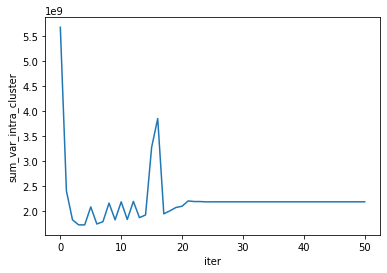

In [ ]:
plot = sns.lineplot(data=df_suma_varianzas_intra_cluster, y='sum_var_intra_cluster', x='iter')

In [ ]:
sort_df_suma_varianzas_intra_cluster.head(7)

,sum_var_intra_cluster,iter
4,1.725662e+09,4
3,1.727426e+09,3
6,1.744155e+09,6
7,1.790306e+09,7
9,1.827519e+09,9
2,1.827944e+09,2
11,1.833913e+09,11


In [ ]:
lista_df_clusters_finales_iter[5]

,observaciones,cluster
0,382,3.0
1,732,1.0
2,1888,2.0
3,679,2.0
4,1004,3.0
...,...,...
1900,1122,0.0
1901,1346,2.0
1902,1406,0.0
1903,1389,1.0


### Prueba con Distancia Canberra

In [ ]:
Distance_Matrix = Matrix_Dist_Canberra(Data_numpy)

Distance_Matrix = Distance_Matrix + Distance_Matrix.T

In [ ]:
lista_df_clusters_finales_iter,  sort_df_suma_varianzas_intra_cluster, df_suma_varianzas_intra_cluster = k_medoids(Data=Data_numpy , Distance_function=Dist_Canberra, q=1, S_inv='none', Distance_Matrix=Distance_Matrix, random_seed=123, k=4, max_n_iter=50)


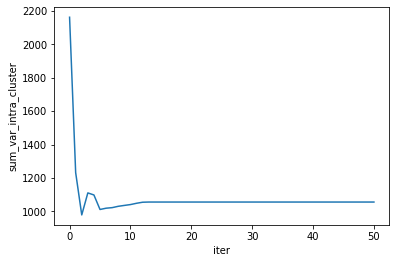

In [ ]:
plot = sns.lineplot(data=df_suma_varianzas_intra_cluster, y='sum_var_intra_cluster', x='iter')

In [ ]:
sort_df_suma_varianzas_intra_cluster.head(7)

,sum_var_intra_cluster,iter
2,978.890348,2
5,1011.428104,5
6,1019.078727,6
7,1022.470984,7
8,1030.463863,8
9,1035.761422,9
10,1040.810428,10


In [ ]:
lista_df_clusters_finales_iter[2]

,observaciones,cluster
0,382,3.0
1,732,2.0
2,1888,0.0
3,679,0.0
4,1004,3.0
...,...,...
1900,1122,0.0
1901,1346,0.0
1902,1406,1.0
1903,1389,2.0


### Prueba Distancia Mahalanobis

In [ ]:
S_inv = np.linalg.inv( np.cov(Data_numpy , rowvar=False) )

In [ ]:
Distance_Matrix = Matrix_Dist_Mahalanobis_3(Data_numpy)

Distance_Matrix = Distance_Matrix + Distance_Matrix.T

In [ ]:
lista_df_clusters_finales_iter,  sort_df_suma_varianzas_intra_cluster, df_suma_varianzas_intra_cluster doids = k_medoids(Data=Data_numpy , Distance_function=Dist_Mahalanobis_2, q=1, S_inv=S_inv, Distance_Matrix=Distance_Matrix, random_seed=123, k=4, max_n_iter=50)


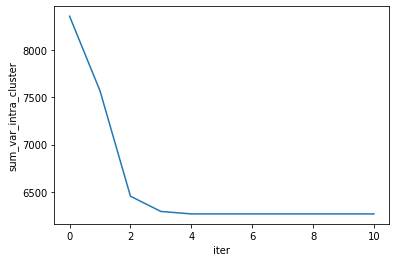

In [ ]:
plot = sns.lineplot(data=df_suma_varianzas_intra_cluster, y='sum_var_intra_cluster', x='iter')

In [ ]:
sort_df_suma_varianzas_intra_cluster.head(7)

In [ ]:
lista_df_clusters_finales_iter[2]

## k-medoids original de Park y Jun 

In [78]:

    lista_df_clusters_finales_iter = []

    ###########################################################################################

    # Se generan los clusters iniciales aleatoreamente

    sample = resample(range(0, len(Data)), n_samples=len(Data), replace=False, random_state=random_seed)

    df_sample = pd.DataFrame({'index': range(0,len(Data)) , 'sample':sample})

    Q = []

    for q in np.arange(0 , 1 + 1/k , 1/k):

        Q.append( np.quantile( range(0, len(Data)) , q ).round(0) )



    labels_clusters = np.array([0])

    for j in range(0,k):
   
        labels_clusters = np.concatenate([labels_clusters, np.repeat( j, len( df_sample.loc[Q[j]:(math.floor(Q[j+1])-1), 'sample'] ) ) ] ) 
 

    df_cluster = pd.DataFrame({'observacion': df_sample['sample'] , 'cluster': labels_clusters})

    lista_df_clusters_finales_iter.append(df_cluster)

    ###########################################################################################



In [80]:
Data = Data_numpy

In [81]:

    # calculamos los medoids de los clusters iniciales

    M = Distance_Matrix

   ######################

    medoids = []

    for j in range(0, k):

      observations_cluster_j = df_cluster.loc[df_cluster.cluster == j ,].observacion

      M_j = M[observations_cluster_j, :][: ,observations_cluster_j] # matriz distancias para el cluster j

      suma_distancias = M_j.sum(axis=1) # suma de la matriz por filas

      h = np.where( suma_distancias == min( suma_distancias ) ) # indice en la matriz de la observacion que minimiza la suma de distancias en el cluster j --> medoid del cluster j

      d = df_cluster.loc[df_cluster.cluster == j , ]    

      # d.iloc[h[0],:].observacion es el indice en el data set original de la observacion medoid del cluster j 


      if len(h[0]) == 1 : 
        
        medoids.append( Data[ d.iloc[h[0],:].observacion , : ]  ) # su componente j es el medoid del cluster j

      if len(h[0]) > 1 : 
        
        medoids.append( Data[ d.iloc[h[0][0],:].observacion , : ]  ) # su componente j es el medoid del cluster j

      # Los condicionales son para evitar problemas en el caso de que en un cluster haya mas de un medoid.
      # Puede haber dos o mas observaciones que cumplan con la definicion de medoid, para alguno de los clusters.
      # Si un cluster tiene varios medoids, nos quedamos solo con uno.

###########################################################################################



In [82]:
h

(array([68], dtype=int64),)

In [85]:
Distance_function = Dist_Euclidea

In [86]:

    # Calculamos la suma de varianzas intra cluster para los clusters iniciales

    lista_suma_varianzas_intra_cluster = []

    distancias, varianzas_intra_cluster , suma_varianzas_intra_cluster = [], [], []

    for j in range(0,k):

        for i in df_cluster.loc[df_cluster.cluster == j, 'observacion']:

            if Distance_function == Dist_Euclidea: distancias.append( Distance_function( Data[i,:] , medoids[j] ) )

            if Distance_function == Dist_Minkowski: distancias.append( Distance_function( Data[i,:] , medoids[j] , q ) )

            if Distance_function == Dist_Canberra: distancias.append( Distance_function( Data[i,:] , medoids[j] ) )

            if Distance_function == Dist_Mahalanobis_2: distancias.append( Distance_function( Data[i,:] , medoids[j] , S_inv) )
            

        varianzas_intra_cluster.append( sum(distancias) )


    suma_varianzas_intra_cluster.append( sum(varianzas_intra_cluster) )

    lista_suma_varianzas_intra_cluster.append( suma_varianzas_intra_cluster )


###########################################################################################



In [87]:
max_n_iter = 10

In [88]:

    # Asignar cada observacion a su cluster más cercano 


    for r in range(0 , max_n_iter):


       # Calculamos los nuevos clusters 

        labels_clusters = []

        for i in df_sample['sample']:

            distancias = []
    
            for j in range(0,k):

                if Distance_function == Dist_Euclidea: distancias.append( Distance_function( Data[i,:] , medoids[j] ) )

                if Distance_function == Dist_Minkowski: distancias.append( Distance_function( Data[i,:] , medoids[j] , q ) )

                if Distance_function == Dist_Canberra: distancias.append( Distance_function( Data[i,:] , medoids[j] ) )

                if Distance_function == Dist_Mahalanobis_2: distancias.append( Distance_function( Data[i,:] , medoids[j] , S_inv) )
            

                

            df_distancias = pd.DataFrame({'Distancias' : distancias , 'Cluster': range(0,k)})

            df_distancias_sort = df_distancias.sort_values(by='Distancias', ascending=True)

            labels_clusters.append( df_distancias_sort.iloc[0]['Cluster'] )

        
        
        df_cluster = pd.DataFrame({'observacion' : df_sample['sample'] , 'cluster': labels_clusters})


###########################################################################################


       # Calculamos los medoids de los nuevos clusters

        medoids = []
        label_medoids =[]


        for j in range(0, k):                    
                
                observations_cluster_j = df_cluster.loc[df_cluster.cluster == j ,].observacion

                M_j = M[observations_cluster_j, :][: ,observations_cluster_j] # matriz distancias para el cluster j

                suma_distancias = M_j.sum(axis=1) # suma de la matriz por filas

                h = np.where( suma_distancias == min( suma_distancias) ) # indice en la matriz de la observacion que minimiza la suma de distancias en el cluster j --> medoid del cluster j

                d = df_cluster.loc[df_cluster.cluster == j , ]    

                # d.iloc[h[0],:].observacion  es el indice en el data set original de la observacion medoid del cluster j 
                
                if len(h[0]) == 1 : 
                    
                    medoids.append( Data[ int(d.iloc[h[0],:].observacion) , : ]  )   # su componente j es el medoid del cluster j

                    label_medoids.append(d.iloc[h[0],:].observacion)


                elif len(h[0]) > 1 : 
                  
                    medoids.append( Data[ int(d.iloc[h[0][0],:].observacion) , : ]  ) # su componente j es el medoid del cluster j
                
                    label_medoids.append(d.iloc[h[0][0],:].observacion)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [89]:
h

(array([ 83, 354], dtype=int64),)

In [96]:
Data[ int(d.iloc[h[0][0],:].observacion) , : ]

array([2.5060439e+01, 5.5202273e+01, 6.7072800e+05, 6.7633384e+01])

In [95]:
int(d.iloc[h[0][0],:].observacion)

1114

In [90]:
d

,observacion,cluster
6,1362,0.0
8,1266,0.0
12,499,0.0
15,565,0.0
17,1809,0.0
...,...,...
1885,942,0.0
1897,1619,0.0
1898,1041,0.0
1900,1122,0.0
